# Houseprice prediction Ensemble Model with PDP Explainer Pipelined Preprocessing

In [1]:
# Import libraries
import sklearn
from scipy.stats import chi2_contingency
import numpy as np
import pandas as pd
from sklearn_pandas import DataFrameMapper
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
gray_cmap=LinearSegmentedColormap.from_list('gy',[(.3,.3,.3),(.8,.8,.8)], N=2) 
np.random.seed(222) #Seed for random numbers generation
import seaborn as sns
%matplotlib inline

import pdpbox as pdb
from pdpbox import pdp, info_plots
from pdpbox.info_plots import TargetPlot, InteractTargetPlot, PredictPlot, InteractPredictPlot
from pdpbox.pdp import PDPInteract, PDPIsolate

from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence


sns.set_style('darkgrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 90)

from sklearn.neighbors import KNeighborsRegressor
import scipy.stats
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from pycaret.regression import setup, compare_models
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import *

from catboost import CatBoostRegressor
from sklearn.linear_model import BayesianRidge, OrthogonalMatchingPursuit
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor

def set_plot_style():
  plt.axis([-2,2,-2,2])
  plt.xlabel('x1')
  plt.ylabel('x2')


In [2]:
print(dir(sklearn.inspection))

['DecisionBoundaryDisplay', 'PartialDependenceDisplay', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_partial_dependence', '_pd_utils', '_permutation_importance', '_plot', 'partial_dependence', 'permutation_importance']


## Data Import

In [3]:
train0 = pd.read_csv('data/house_prices/train.csv')
test0 = pd.read_csv('data/house_prices/test.csv')

In [4]:
# Split original training set into train and validation sets
train_set, val_set = train_test_split(train0, test_size=0.2, random_state=42)

In [5]:
# Separate features and targets for train and validation sets
X_train = train_set.drop(['Id', 'SalePrice'], axis=1)
y_train = train_set['SalePrice']

X_val = val_set.drop(['Id', 'SalePrice'], axis=1)
y_val = val_set['SalePrice']

# Separate features for test set
X_test = test0.drop('Id', axis=1)

## Preprocessing:

### Cleaning

In [6]:
# Define columns
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

In [7]:
# Pipeline 1: Imputation
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5))])

categorical_transformer= Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))])

preprocessor1 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)])

# Fit and Transform
preprocessor1.fit(X_train)
X_train_imputed = pd.DataFrame(preprocessor1.transform(X_train), columns=numeric_cols + categorical_cols)
X_val_imputed = pd.DataFrame(preprocessor1.transform(X_val), columns=numeric_cols + categorical_cols)
X_test_imputed = pd.DataFrame(preprocessor1.transform(X_test), columns=numeric_cols + categorical_cols)

# Cast numeric columns back to their original types
X_train_imputed[numeric_cols] = X_train_imputed[numeric_cols].apply(pd.to_numeric, errors='coerce')
X_val_imputed[numeric_cols] = X_val_imputed[numeric_cols].apply(pd.to_numeric, errors='coerce')
X_test_imputed[numeric_cols] = X_test_imputed[numeric_cols].apply(pd.to_numeric, errors='coerce')

In [8]:
X_train_imputed

MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0           20.0         70.0   8400.0          5.0          6.0     1957.0   
1           60.0         59.0   7837.0          6.0          7.0     1993.0   
2           30.0         67.0   8777.0          5.0          7.0     1910.0   
3           50.0         60.0   7200.0          5.0          7.0     1937.0   
4           50.0         50.0   5000.0          5.0          6.0     1924.0   
...          ...          ...      ...          ...          ...        ...   
1163        20.0         78.0   9317.0          6.0          5.0     2006.0   
1164        50.0         65.0   7804.0          4.0          3.0     1928.0   
1165        20.0         60.0   8172.0          5.0          7.0     1955.0   
1166        50.0         55.0   7642.0          7.0          8.0     1918.0   
1167       120.0         53.0   3684.0          7.0          5.0     2007.0   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  \
0           1957.0         0.0       922.0         0.0      392.0   
1           1994.0         0.0         0.0         0.0      799.0   
2           1950.0         0.0         0.0         0.0      796.0   
3           1950.0       252.0       569.0         0.0      162.0   
4           1950.0         0.0       218.0         0.0      808.0   
...            ...         ...         ...         ...        ...   
1163        2006.0         0.0        24.0         0.0     1290.0   
1164        1950.0         0.0       622.0         0.0      500.0   
1165        1990.0         0.0       167.0         0.0      697.0   
1166        1998.0         0.0         0.0         0.0      912.0   
1167        2007.0       130.0         0.0         0.0     1373.0   

      TotalBsmtSF  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  \
0          1314.0    1314.0       0.0           0.0     1314.0           1.0   
1           799.0     799.0     772.0           0.0     1571.0           0.0   
2           796.0     796.0       0.0           0.0      796.0           0.0   
3           731.0     981.0     787.0           0.0     1768.0           1.0   
4          1026.0    1026.0     665.0           0.0     1691.0           0.0   
...           ...       ...       ...           ...        ...           ...   
1163       1314.0    1314.0       0.0           0.0     1314.0           0.0   
1164       1122.0    1328.0     653.0           0.0     1981.0           1.0   
1165        864.0     864.0       0.0           0.0      864.0           1.0   
1166        912.0     912.0     514.0           0.0     1426.0           0.0   
1167       1373.0    1555.0       0.0           0.0     1555.0           0.0   

      BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  \
0              0.0       1.0       0.0           3.0           1.0   
1              0.0       2.0       1.0           3.0           1.0   
2              0.0       1.0       0.0           2.0           1.0   
3              0.0       1.0       1.0           3.0           1.0   
4              0.0       2.0       0.0           3.0           1.0   
...            ...       ...       ...           ...           ...   
1163           0.0       2.0       0.0           3.0           1.0   
1164           0.0       2.0       0.0           4.0           1.0   
1165           0.0       1.0       0.0           2.0           1.0   
1166           0.0       1.0       1.0           3.0           1.0   
1167           0.0       2.0       0.0           2.0           1.0   

      TotRmsAbvGrd  Fireplaces  GarageYrBlt  GarageCars  GarageArea  \
0              5.0         0.0       1957.0         1.0       294.0   
1              7.0         1.0       1993.0         2.0       380.0   
2              4.0         0.0       1948.0         0.0         0.0   
3              7.0         2.0       1939.0         1.0       240.0   
4              6.0         1.0       1924.0         1.0       308.0   


### Correlation Correction

In [9]:
# Pipeline 2: Correlation Correction

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


class RemoveCorrelatedFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.7, categorical_threshold=0.7):
        self.threshold = threshold
        self.categorical_threshold = categorical_threshold

    def fit(self, X, y=None):
        self.correlated_features = set()
        self.correlated_categorical_features = set()
        
        # For numerical features
        correlation_matrix = X.corr()

        for i in range(len(correlation_matrix.columns)):
            for j in range(i):
                if abs(correlation_matrix.iloc[i, j]) > self.threshold:
                    colname = correlation_matrix.columns[i]
                    self.correlated_features.add(colname)
        
        # For categorical features
        cat_cols = X.select_dtypes(include=['object']).columns.tolist()
        for i, col1 in enumerate(cat_cols):
            for j, col2 in enumerate(cat_cols[i+1:]):
                if cramers_v(X[col1], X[col2]) > self.categorical_threshold:
                    self.correlated_categorical_features.add(col2)
        
        return self

    def transform(self, X, y=None):
        X = X.drop(columns=self.correlated_features)
        X = X.drop(columns=self.correlated_categorical_features)
        return X

preprocessor2 = Pipeline(steps=[
    ('remove_correlated_features', RemoveCorrelatedFeatures(threshold=0.7, categorical_threshold=0.6))
])

preprocessor2.fit(X_train_imputed)
X_train_corrected = pd.DataFrame(preprocessor2.transform(X_train_imputed))
X_val_corrected = pd.DataFrame(preprocessor2.transform(X_val_imputed))
X_test_corrected = pd.DataFrame(preprocessor2.transform(X_test_imputed))

In [10]:
X_train_corrected

MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0           20.0         70.0   8400.0          5.0          6.0     1957.0   
1           60.0         59.0   7837.0          6.0          7.0     1993.0   
2           30.0         67.0   8777.0          5.0          7.0     1910.0   
3           50.0         60.0   7200.0          5.0          7.0     1937.0   
4           50.0         50.0   5000.0          5.0          6.0     1924.0   
...          ...          ...      ...          ...          ...        ...   
1163        20.0         78.0   9317.0          6.0          5.0     2006.0   
1164        50.0         65.0   7804.0          4.0          3.0     1928.0   
1165        20.0         60.0   8172.0          5.0          7.0     1955.0   
1166        50.0         55.0   7642.0          7.0          8.0     1918.0   
1167       120.0         53.0   3684.0          7.0          5.0     2007.0   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  \
0           1957.0         0.0       922.0         0.0      392.0   
1           1994.0         0.0         0.0         0.0      799.0   
2           1950.0         0.0         0.0         0.0      796.0   
3           1950.0       252.0       569.0         0.0      162.0   
4           1950.0         0.0       218.0         0.0      808.0   
...            ...         ...         ...         ...        ...   
1163        2006.0         0.0        24.0         0.0     1290.0   
1164        1950.0         0.0       622.0         0.0      500.0   
1165        1990.0         0.0       167.0         0.0      697.0   
1166        1998.0         0.0         0.0         0.0      912.0   
1167        2007.0       130.0         0.0         0.0     1373.0   

      TotalBsmtSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  \
0          1314.0       0.0           0.0     1314.0           1.0   
1           799.0     772.0           0.0     1571.0           0.0   
2           796.0       0.0           0.0      796.0           0.0   
3           731.0     787.0           0.0     1768.0           1.0   
4          1026.0     665.0           0.0     1691.0           0.0   
...           ...       ...           ...        ...           ...   
1163       1314.0       0.0           0.0     1314.0           0.0   
1164       1122.0     653.0           0.0     1981.0           1.0   
1165        864.0       0.0           0.0      864.0           1.0   
1166        912.0     514.0           0.0     1426.0           0.0   
1167       1373.0       0.0           0.0     1555.0           0.0   

      BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  \
0              0.0       1.0       0.0           3.0           1.0   
1              0.0       2.0       1.0           3.0           1.0   
2              0.0       1.0       0.0           2.0           1.0   
3              0.0       1.0       1.0           3.0           1.0   
4              0.0       2.0       0.0           3.0           1.0   
...            ...       ...       ...           ...           ...   
1163           0.0       2.0       0.0           3.0           1.0   
1164           0.0       2.0       0.0           4.0           1.0   
1165           0.0       1.0       0.0           2.0           1.0   
1166           0.0       1.0       1.0           3.0           1.0   
1167           0.0       2.0       0.0           2.0           1.0   

      Fireplaces  GarageCars  WoodDeckSF  OpenPorchSF  EnclosedPorch  \
0            0.0         1.0       250.0          0.0            0.0   
1            1.0         2.0         0.0         40.0            0.0   
2            0.0         0.0       328.0          0.0          164.0   
3            2.0         1.0         0.0          0.0          264.0   
4            1.0         1.0         0.0          0.0          242.0   
...          ...         ...         ...          ...            ...   
1163         1.0         2.0         0.0  

In [11]:
categorical_features = X_train_corrected.select_dtypes(include=['object']).columns.tolist()

### Feature Normalization

In [12]:
# Pipeline 3: Numerical Feature Normalization
class LogTransformSkewedFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, skew_threshold=0.5):
        self.skew_threshold = skew_threshold

    def fit(self, X, y=None):
        numeric_data = X.select_dtypes(np.number)
        skew_df = pd.DataFrame(numeric_data.columns, columns=['Feature'])
        skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: scipy.stats.skew(X[feature]))
        skew_df['Absolute Skew'] = skew_df['Skew'].apply(abs)
        skew_df['Skewed'] = skew_df['Absolute Skew'].apply(lambda x: True if x >= self.skew_threshold else False)
        self.skewed_features = skew_df.query("Skewed == True")['Feature'].values
        return self

    def transform(self, X, y=None):
        X_transformed = X.copy()
        for column in self.skewed_features:
            X_transformed[column] = np.log1p(X_transformed[column])
        return X_transformed

preprocessor3 = Pipeline(steps=[
    ('log_transform_skewed_features', LogTransformSkewedFeatures(skew_threshold=0.5))
])

# Fit the pipeline to the training data
preprocessor3.fit(X_train_corrected)

# Transform all data sets
X_train_normalized = pd.DataFrame(preprocessor3.transform(X_train_corrected))
X_val_normalized = pd.DataFrame(preprocessor3.transform(X_val_corrected))
X_test_normalized = pd.DataFrame(preprocessor3.transform(X_test_corrected))


In [13]:
X_train_normalized

MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
0       3.044522     4.262680  9.036106          5.0     1.945910   7.579679   
1       4.110874     4.094345  8.966739          6.0     2.079442   7.597898   
2       3.433987     4.219508  9.080004          5.0     2.079442   7.555382   
3       3.931826     4.110874  8.881975          5.0     2.079442   7.569412   
4       3.931826     3.931826  8.517393          5.0     1.945910   7.562681   
...          ...          ...       ...          ...          ...        ...   
1163    3.044522     4.369448  9.139703          6.0     1.791759   7.604396   
1164    3.931826     4.189655  8.962520          4.0     1.386294   7.564757   
1165    3.044522     4.110874  9.008591          5.0     2.079442   7.578657   
1166    3.931826     4.025352  8.941545          7.0     2.197225   7.559559   
1167    4.795791     3.988984  8.212026          7.0     1.791759   7.604894   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  \
0         7.579679    0.000000    6.827629         0.0   5.973810   
1         7.598399    0.000000    0.000000         0.0   6.684612   
2         7.576097    0.000000    0.000000         0.0   6.680855   
3         7.576097    5.533389    6.345636         0.0   5.093750   
4         7.576097    0.000000    5.389072         0.0   6.695799   
...            ...         ...         ...         ...        ...   
1163      7.604396    0.000000    3.218876         0.0   7.163172   
1164      7.576097    0.000000    6.434547         0.0   6.216606   
1165      7.596392    0.000000    5.123964         0.0   6.548219   
1166      7.600402    0.000000    0.000000         0.0   6.816736   
1167      7.604894    4.875197    0.000000         0.0   7.225481   

      TotalBsmtSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  \
0        7.181592  0.000000           0.0   7.181592      0.693147   
1        6.684612  6.650279           0.0   7.360104      0.000000   
2        6.680855  0.000000           0.0   6.680855      0.000000   
3        6.595781  6.669498           0.0   7.478170      0.693147   
4        6.934397  6.501290           0.0   7.433667      0.000000   
...           ...       ...           ...        ...           ...   
1163     7.181592  0.000000           0.0   7.181592      0.000000   
1164     7.023759  6.483107           0.0   7.591862      0.693147   
1165     6.762730  0.000000           0.0   6.762730      0.693147   
1166     6.816736  6.244167           0.0   7.263330      0.000000   
1167     7.225481  0.000000           0.0   7.349874      0.000000   

      BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  \
0              0.0       1.0  0.000000           3.0      0.693147   
1              0.0       2.0  0.693147           3.0      0.693147   
2              0.0       1.0  0.000000           2.0      0.693147   
3              0.0       1.0  0.693147           3.0      0.693147   
4              0.0       2.0  0.000000           3.0      0.693147   
...            ...       ...       ...           ...           ...   
1163           0.0       2.0  0.000000           3.0      0.693147   
1164           0.0       2.0  0.000000           4.0      0.693147   
1165           0.0       1.0  0.000000           2.0      0.693147   
1166           0.0       1.0  0.693147           3.0      0.693147   
1167           0.0       2.0  0.000000           2.0      0.693147   

      Fireplaces  GarageCars  WoodDeckSF  OpenPorchSF  EnclosedPorch  \
0       0.000000         1.0    5.525453     0.000000       0.000000   
1       0.693147         2.0    0.000000     3.713572       0.000000   
2       0.000000         0.0    5.796058     0.000000       5.105945   
3       1.098612         1.0    0.000000     0.000000       5.579730   
4       0.693147         1.0    0.000000     0.000000       5.493061   
...          ...         ...         ...          ...            ...   
1163    0.693147         2.0  

### Encoding & Scaling:

In [14]:
# Pipeline 4: Encode Categoricals & Scale Numericals
categorical_columns = X_train_normalized.select_dtypes(include=['object']).columns.tolist()
numerical_columns = X_train_normalized.select_dtypes(include=['float64']).columns.tolist()

# Custom Transformer to handle LabelEncoding for multiple columns
class CustomLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, default_label="UNKNOWN"):
        self.label_encoders = {}
        self.default_label = default_label
        
    def fit(self, X, y=None):
        for col in X.columns:
            le = LabelEncoder()
            # Add a default category for unseen labels
            unique_values = pd.Series([self.default_label]).append(X[col])
            le.fit(unique_values)
            self.label_encoders[col] = le
        return self
    
    def transform(self, X):
        X_encoded = X.copy()
        for col in X.columns:
            le = self.label_encoders[col]
            # Replace unseen labels with the default label
            X_encoded[col] = X[col].apply(lambda x: x if x in le.classes_ else self.default_label)
            X_encoded[col] = le.transform(X_encoded[col])
        return X_encoded

# Label encoder pipeline for categorical features
categorical_transformer = Pipeline(steps=[
    ('labelencoder', CustomLabelEncoder(default_label='UNKNOWN'))
])

# Standard scaler for numerical features
numerical_transformer = Pipeline(steps=[
    ('standardscaler', StandardScaler())
])

# Column transformer
preprocessor4 = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

# Fitting the pipeline to your training data
preprocessor4.fit(X_train_normalized)

# Transforming the datasets
X_train_final = preprocessor4.transform(X_train_normalized)
X_val_final = preprocessor4.transform(X_val_normalized)
X_test_final = preprocessor4.transform(X_test_normalized)


# Combine the two lists of feature names in the order that the ColumnTransformer uses them
combined_feature_names = numerical_columns + categorical_columns

# Converting them back to DataFrames
X_train_final = pd.DataFrame(X_train_final, columns=combined_feature_names)
X_val_final = pd.DataFrame(X_val_final, columns=combined_feature_names)
X_test_final = pd.DataFrame(X_test_final, columns=combined_feature_names)

In [15]:
X_train_final

MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
0      -1.119827     0.096037 -0.167026    -0.820445     0.446822  -0.446988   
1       0.426854    -0.400841 -0.301310    -0.088934     1.240068   0.718794   
2      -0.554931    -0.031395 -0.082046    -0.820445     1.240068  -2.001666   
3       0.167155    -0.352051 -0.465400    -0.820445     1.240068  -1.103942   
4       0.167155    -0.880550 -1.171176    -0.820445     0.446822  -1.534608   
...          ...          ...       ...          ...          ...        ...   
1163   -1.119827     0.411185  0.033523    -0.088934    -0.468913   1.134605   
1164    0.167155    -0.119512 -0.309477    -1.551955    -2.877586  -1.401786   
1165   -1.119827    -0.352051 -0.220290    -0.820445     1.240068  -0.512381   
1166    0.167155    -0.604488 -0.350081     0.642577     1.939760  -1.734358   
1167    1.420285    -0.711834 -1.762321     0.642577    -0.468913   1.166479   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  \
0        -1.346711   -0.834982    0.865283   -0.351357   0.171738   
1         0.442246   -0.834982   -1.416429   -0.351357   0.557902   
2        -1.688962   -0.834982   -1.416429   -0.351357   0.555860   
3        -1.688962    1.268126    0.704206   -0.351357  -0.306380   
4        -1.688962   -0.834982    0.384534   -0.351357   0.563979   
...            ...         ...         ...         ...        ...   
1163      1.015329   -0.834982   -0.340719   -0.351357   0.817893   
1164     -1.688962   -0.834982    0.733919   -0.351357   0.303644   
1165      0.250452   -0.834982    0.295938   -0.351357   0.483802   
1166      0.633655   -0.834982   -1.416429   -0.351357   0.629682   
1167      1.062931    1.017963   -1.416429   -0.351357   0.851745   

      TotalBsmtSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  \
0        0.374650 -0.879468     -0.134113  -0.292584      1.148016   
1       -0.069945  1.137011     -0.134113   0.250597     -0.832665   
2       -0.073306 -0.879468     -0.134113  -1.816242     -0.832665   
3       -0.149413  1.142838     -0.134113   0.609851      1.148016   
4        0.153511  1.091835     -0.134113   0.474436     -0.832665   
...           ...       ...           ...        ...           ...   
1163     0.374650 -0.879468     -0.134113  -0.292584     -0.832665   
1164     0.233454  1.086321     -0.134113   0.955796      1.148016   
1165    -0.000062 -0.879468     -0.134113  -1.567111      1.148016   
1166     0.048252  1.013871     -0.134113  -0.043871     -0.832665   
1167     0.413913 -0.879468     -0.134113   0.219468     -0.832665   

      BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  \
0        -0.244079 -1.055566 -0.770901      0.136218     -0.208048   
1        -0.244079  0.773664  1.263103      0.136218     -0.208048   
2        -0.244079 -1.055566 -0.770901     -1.106774     -0.208048   
3        -0.244079 -1.055566  1.263103      0.136218     -0.208048   
4        -0.244079  0.773664 -0.770901      0.136218     -0.208048   
...            ...       ...       ...           ...           ...   
1163     -0.244079  0.773664 -0.770901      0.136218     -0.208048   
1164     -0.244079  0.773664 -0.770901      1.379210     -0.208048   
1165     -0.244079 -1.055566 -0.770901     -1.106774     -0.208048   
1166     -0.244079 -1.055566  1.263103      0.136218     -0.208048   
1167     -0.244079  0.773664 -0.770901     -1.106774     -0.208048   

      Fireplaces  GarageCars  WoodDeckSF  OpenPorchSF  EnclosedPorch  \
0      -1.021906   -1.056544    1.184573    -1.096169      -0.395124   
1       0.734914    0.295092   -0.932610     0.617419      -0.395124   
2      -1.021906   -2.408179    1.288260    -1.096169       2.590754   
3       1.762589   -1.056544   -0.932610    -1.096169       2.867816   
4       0.734914   -1.056544   -0.932610    -1.096169       2.817134   
...          ...         ...         ...          ...            ...   
1163    0.734914    0.295092  

## Catboost Regressor

In [16]:
catboost = CatBoostRegressor(verbose=0)
catboost.fit(X_train_corrected, y_train, cat_features=categorical_features)

catboost_predict = np.exp(catboost.predict(X_test_corrected))


In [17]:
final_predictions = catboost.predict(X_test_corrected)

## Importing true SalePrice values

In [18]:
true_prices = pd.read_csv('data/house_prices/solution.csv')


In [19]:
y_true = true_prices['SalePrice'].values

## Metrics

In [20]:
print('Mean absolute error: ' + str(mean_absolute_error(y_true,final_predictions)))
print('Mean squared error: ' + str(mean_squared_error(y_true,final_predictions)))
print('Root mean squared error: ' + str(np.sqrt(mean_squared_error(y_true,final_predictions))))

Mean absolute error: 14062.560909211776
Mean squared error: 480868814.90550715
Root mean squared error: 21928.7212327921


In [21]:
print('Explained variance score: ' + str(explained_variance_score(y_true,final_predictions)))

Explained variance score: 0.9263158907005983


In [22]:

print('R2 score: ' + str(r2_score(y_true,final_predictions)))

R2 score: 0.9257841876569299


###### -> R2 score of 0.919 indicates good model quality

## PDP Explainer

### Single Feature Partial Dependence Plots

In [23]:
column_index_1 = X_test_corrected.columns.get_loc('GrLivArea')

In [24]:
print("Integer location of 'Feature 1':", column_index_1)

Integer location of 'Feature 1': 14


In [25]:
column_index_2 = X_test_corrected.columns.get_loc('OverallQual')

In [26]:
print("Integer location of 'Feature 2':", column_index_2)

Integer location of 'Feature 2': 3


In [27]:
features = [14, 3, (14, 3)]

<Figure size 800x550 with 0 Axes>

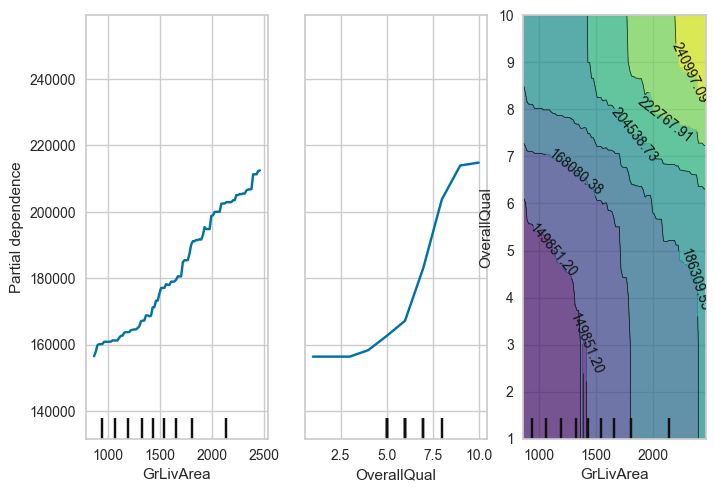

In [37]:
plt.set_cmap('viridis')
PartialDependenceDisplay.from_estimator(catboost, X_test_corrected, features)
# Save the plot to the specified directory
plt.savefig('figures/pdp/top_2_partial_dependence.png', bbox_inches='tight', dpi=300)

plt.show()

TypeError: plot() takes 1 positional argument but 2 were given

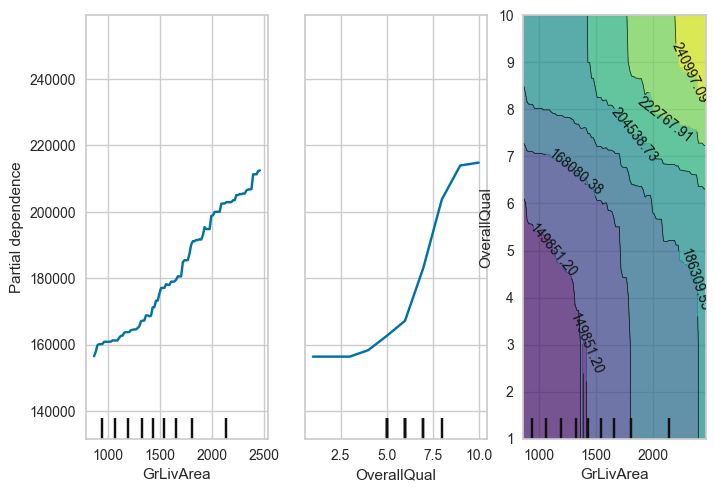

In [41]:
# Create the partial dependence plot
display = PartialDependenceDisplay.from_estimator(catboost, X_test_corrected, features)

# Modify the y-axis label for the first feature
display.plot([0]).set_ylabels("Predicted House Price in dollars")

# Save the plot to the specified directory
display.figure_.savefig('figures/pdp/top_2_partial_dependence.png', bbox_inches='tight', dpi=300)

# Show the modified plot
plt.show()